In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.model_selection import GridSearchCV, train_test_split, GroupShuffleSplit, cross_validate, GroupKFold, StratifiedGroupKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import xgboost as xgb
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud 
from sentence_transformers import SentenceTransformer, util
import statsmodels.formula.api as smf
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, recall_score, balanced_accuracy_score
import umap
from sklearn.cluster import KMeans
import plotly.express as px
import nltk # pip install nltk
from transformers import BertTokenizer, BertModel
import torch
import plotly.express as px
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from boruta import BorutaPy



import os
try:
    os.chdir('./Animal_Adoption_ML_Python/')
except FileNotFoundError:
    pass
#https://github.com/thomaskbrown18/pet_adoption_ML_proj

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'



sns.set(font_scale = 2)
sns.set_palette('muted')
sns.set_style(style='darkgrid')

# Work-flow:
1. Load data
2. Split into train test
3. Clean, dummy out the train data
4. write a function that will allign test/train of any data set
3. Attempt balancing 
    - 3.1. Undersample majority class
    - 3.2. SMOTE directly into model
    - 3.3. Split data so its 50/50 in training
    - 3.4. Keep as is
4. Feature Imporatnce 
    - 4.1. Boruta
    - 4.2. SMOTE
    - 4.3. Manual
    - 4.4. None
5. Run baselines
6. Fine tune models
7. XAI
    - 7.1. SHAP



I want to ensure I catch all unadopted animals more than anything, so a measure that aims at this is what I need (recall)

# Load and Break Data into Animal Types

In [2]:
df = pd.read_csv('cleaned_df', index_col=0)
df_dog = (df.loc[df.animal_type=='Dog'])

#flip the adopted outcome so the minority class (not adopted) is our '1' value.
df_dog['not_adopted'] = np.where(df_dog['adopted'] == 1, 0, 1)

Break into Test and Train Data:

In [3]:
#Split 
train_ix, test_ix = next(GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=10).split(df_dog, groups=df_dog['animal_id']))
train = df_dog.iloc[train_ix]
test = df_dog.iloc[test_ix]

def print_imbalance(df, y):
    neg = df[y].value_counts()[0]
    pos = df[y].value_counts()[1]
    print('Class 0 for {} is: {}'.format(y, neg))
    print('Class 1 in {} is: {}'.format(y, pos))
    print('Proportion class 1 is {:.2f}'.format(pos/(pos+neg)))

print('Train:')
print_imbalance(train, 'not_adopted')

print('\Validation:')
print_imbalance(test, 'not_adopted')


Train:
Class 0 for not_adopted is: 49730
Class 1 in not_adopted is: 16804
Proportion class 1 is 0.25
\Validation:
Class 0 for not_adopted is: 12518
Class 1 in not_adopted is: 4061
Proportion class 1 is 0.24


Define Cleaning Functions:

In [4]:

def dummy_breed_color(df, var_list):
    for var in var_list:
        var_one = var + '_one'
        var_two = var + '_two'
        temp_df = df[['animal_id',var_one, var_two]]
        var_one_encoded = pd.get_dummies(temp_df[var_one], prefix=var)
        var_two_encoded = pd.get_dummies(temp_df[var_two], prefix=var)
        merged = var_one_encoded.add(var_two_encoded, fill_value=0)
        merged = pd.concat([temp_df['animal_id'], merged], axis=1)
        merged = merged.groupby('animal_id').sum()
        merged = merged.applymap(lambda x: 1 if x>1 else x).reset_index()
        df = df.merge(merged, left_on='animal_id', right_on='animal_id', how='left')
        df.drop(columns=[var_one, var_two, var+'_drop', var], inplace=True)
    return df 

def create_cat(df, var_list):
    for var in var_list:
        if df[var].nunique() == 2:
            temp = pd.get_dummies(df[var], prefix=var, drop_first=True)
        else:
            temp = pd.get_dummies(df[var], prefix=var)
        df = pd.concat([df.drop(columns=var),temp], axis=1)
    return df

def log_values(df, var_list):
    for i in var_list:
        df[i] = np.log(df[i]+1)
    return df 

def drop_low_cats(df, var_list, drop_val):
    counts = df.loc[:, df.columns.str.contains('|'.join(var_list))].sum()
    mask = counts < drop_val
    # get the index values where the mask is True and store them in a list
    index_list = list(counts[mask].index)
    for i in index_list:
        str_name = i.split('_')[0]
        df.loc[df[i] == 1, str_name+'_uncommon'] = 1
    df.loc[:, df.columns.str.contains('_uncommon')] = df.loc[:, df.columns.str.contains('_uncommon')].fillna(0)
    df.drop(columns=index_list, inplace=True)
    return df, index_list

def standardize_nums(df, var_list):
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='mean')),
        ('standardize', StandardScaler())
    ])
    ans = num_pipe.fit_transform(df[var_list])
    df.loc[:, var_list] = ans
    return df, num_pipe

def transform_nums(df, var_list, num_pipe):
    ans = num_pipe.transform(df[var_list])
    df.loc[:, var_list] = ans
    return df

def transform_low_cats(df, index_list):
    new_list = df.loc[:, df.columns.isin(index_list)].columns
    for i in new_list:
        str_name = i.split('_')[0]
        df.loc[df[i] == 1, str_name+'_uncommon'] = 1
    df.loc[:, df.columns.str.contains('_uncommon')] = df.loc[:, df.columns.str.contains('_uncommon')].fillna(0)
    df.drop(columns=new_list, inplace=True)
    return df


def align_train_n_test(train, test):
    a, b = train.align(test, join='inner', axis=1)
    return a, b

def full_clean(train, test, cat_vars, num_vars, special_vars):
    train_clean = (train
    .pipe(dummy_breed_color, special_vars)
    .pipe(create_cat, cat_vars)
    .pipe(log_values, num_vars)
    )
    test_clean = (test
    .pipe(dummy_breed_color, special_vars)
    .pipe(create_cat, cat_vars)
    .pipe(log_values, num_vars)
    )
    #standardize my numericals
    train_clean, num_pipe = train_clean.pipe(standardize_nums, num_vars)
    test_clean = test_clean.pipe(transform_nums, num_vars, num_pipe)

    #drop low categoricals in train, apply to test
    train_clean, index_list = train_clean.pipe(drop_low_cats, cat_vars+special_vars, 5)
    test_clean = test_clean.pipe(transform_low_cats, index_list)

    #align both dataframes
    train_clean, test_clean = align_train_n_test(train_clean, test_clean)

    return train_clean, test_clean






Specify baseline features I will use.

In [5]:
num_feats = ['age', 'intake_count']
cat_feats = ['intake_type', 'intake_condition', 'sex_upon_intake', 'name_avail', 'intake_month', 'mixed']
special_feats = ['breed', 'color']
x = num_feats+cat_feats+special_feats
y='not_adopted'

In [6]:
train_clean = (train
.pipe(dummy_breed_color, special_feats)
.pipe(create_cat, cat_feats)
.pipe(log_values, num_feats)
)

val_clean = (test
.pipe(dummy_breed_color, special_feats)
.pipe(create_cat, cat_feats)
.pipe(log_values, num_feats)
)

#standardize my numericals
train_clean, num_pipe = train_clean.pipe(standardize_nums, num_feats)
val_clean = val_clean.pipe(transform_nums, num_feats, num_pipe)

#drop low categoricals in train, apply to test
train_clean, index_list = train_clean.pipe(drop_low_cats, cat_feats+special_feats, 5)
val_clean = val_clean.pipe(transform_low_cats, index_list)
print(train_clean.shape, val_clean.shape)

#align both dataframes
train_clean, val_clean = align_train_n_test(train_clean, val_clean)
print(train_clean.shape, val_clean.shape)


(66534, 242) (16579, 240)
(66534, 237) (16579, 237)


In [7]:
#Break into X and Y's and get my cross validation folds
X_train = train_clean.loc[:, train_clean.columns.str.contains('|'.join(x))]
y_train = train_clean.loc[:, y]
X_val = val_clean.loc[:, val_clean.columns.str.contains('|'.join(x))]
y_val = val_clean.loc[:,y]


group_kfold = GroupKFold(n_splits=5)
cv = group_kfold.split(X_train, y_train, train_clean['animal_id'])


## Specify Baseline Models

In [8]:
#Specify Naive Models
model_run_dict = {
    'log_l2': LogisticRegression(penalty='l2',solver='saga',C=.01,max_iter=1000),
    'tree': DecisionTreeClassifier(random_state=1),
    'rfc_tree': RandomForestClassifier(random_state=1),
    'xgb_tree': xgb.XGBClassifier(random_state=1)
}

#output of models
fitted_models = {}


#Specify train data to test over
datasets_to_run = {
    'all_features': X_train,
}

#validation output results
val_df = pd.DataFrame()


In [9]:
def run_model(model_name, model, x, y, grp,df=val_df, return_scores = 0):
    group_kfold = GroupKFold(n_splits=5)
    cv = group_kfold.split(x, y, grp)
    scores = cross_validate(model, x, y, 
    scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall', 'f1'), 
    cv=cv,
    n_jobs=-1)
    print(model_name, ': Done!')
    scores_df = pd.DataFrame(scores).round(3)
    df = pd.DataFrame(scores).mean().round(3).to_frame().T
    df = df.loc[:, df.columns.str.contains('test_')]
    df['model_name'] = model_name
    if return_scores == 1:
        return df, scores_df
    else:
        return df

def predict_model(model_name,model,x_train,x = X_val, y = y_val, df = val_df):

    #align the data beforehand
    _, x = align_train_n_test(x_train, x)

    predict_val = model.predict(x)
    print(model_name, ': Done!')
    predict_prob_val = model.predict_proba(x)[:,1]
    report = classification_report(y, predict_val,output_dict=True)
    report['1']['roc_auc_score'] = roc_auc_score(y, predict_prob_val)
    report['1']['balanced accuracy'] = balanced_accuracy_score(y, predict_val)
    report['1']['accuracy'] = report['accuracy']
    report['1']['model'] = model_name
    df = pd.DataFrame(report['1'], index=[0])
    
    return df 

In [10]:
run_initial_models = False

if run_initial_models:
    ans = run_model(model_name='dummy',model=DummyClassifier(strategy='most_frequent'), x=X_train, y=y_train, grp=train['animal_id'])    
    val_df = pd.concat([val_df, ans], ignore_index=True)

    #Train all of our models
    for model_name, model_run in model_run_dict.items():
        ans = run_model(model_name=model_name,model=model_run, x=X_train, y=y_train, grp=train['animal_id'])
        val_df = pd.concat([val_df, ans], ignore_index=True)

# Attempt Balancing of Data

1. stratify kfold
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5)
sgkf.split(X_train, y_train, train_clean['animal_id'])
cross_validate(xgb.XGBClassifier(random_state=1), X_train, y_train, 
    scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'precision', 'recall'), 
    groups= train_clean['animal_id'],
    cv=sgkf,
    n_jobs=-1)

{'fit_time': array([35.78868747, 35.47714162, 33.9041729 , 31.87138557, 35.57765579]),
 'score_time': array([0.3065424 , 0.36354876, 0.37324929, 0.38705349, 0.30254912]),
 'test_accuracy': array([0.78832281, 0.78994439, 0.78717968, 0.78740513, 0.7874643 ]),
 'test_balanced_accuracy': array([0.60811397, 0.61099006, 0.60844194, 0.60957769, 0.6069544 ]),
 'test_roc_auc': array([0.72766735, 0.7309533 , 0.72612159, 0.73020441, 0.72715069]),
 'test_precision': array([0.74817518, 0.75495495, 0.73345102, 0.73130435, 0.74270073]),
 'test_recall': array([0.24397501, 0.24933056, 0.24724784, 0.25022315, 0.2422619 ])}

1. Duplicate the minority class

In [ ]:
outcome_0_train = train_clean[train_clean[y] == 0]
outcome_1_train = train_clean[train_clean[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')

upsampled_class_1_no = outcome_1_train.sample(
    n=len(outcome_0_train), replace=True, random_state=1)
train_duplicate_upsample = pd.concat([outcome_0_train, upsampled_class_1_no])
train_duplicate_upsample = train_duplicate_upsample.sample(frac=1).reset_index(drop=True)

outcome_0_train = train_duplicate_upsample[train_duplicate_upsample[y] == 0]
outcome_1_train = train_duplicate_upsample[train_duplicate_upsample[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')

X_duplicate_upsample = train_duplicate_upsample.loc[:, train_duplicate_upsample.columns.str.contains('|'.join(x))]
y_duplicate_upsample = train_duplicate_upsample[y]

datasets_to_run['duplicate_upsample'] = X_duplicate_upsample

Class 0 in Training proportion is: 49730
Class 1 in Training proportion is: 16804
Class 0 in Training proportion is: 49730
Class 1 in Training proportion is: 49730


In [ ]:
for model_name, model_run in model_run_dict.items():
    imba_pipeline = make_pipeline(RandomOverSampler(sampling_strategy='minority', random_state=1), 
                              model_run)
    ans = run_model(model_name=model_name+'_oversample',model=imba_pipeline, x=X_train, y=y_train, grp=train['animal_id'])
    val_df = pd.concat([val_df, ans], ignore_index=True)

log_l2_oversample : Done!
tree_oversample : Done!
rfc_tree_oversample : Done!
xgb_tree_oversample : Done!


2. Utilize SMOTE to balance data

In [ ]:
smote_model = SMOTE(random_state=1, sampling_strategy='minority')
datasets_to_run['smote'] = smote_model.fit_resample(X_train, y_train)[0]

for model_name, model_run in model_run_dict.items():
    imba_pipeline = make_pipeline(SMOTE(random_state=1, sampling_strategy='minority'), 
                              model_run)
    ans = run_model(model_name=model_name+'_smote',model=imba_pipeline, x=X_train, y=y_train, grp=train['animal_id'])
    val_df = pd.concat([val_df, ans], ignore_index=True)


log_l2_smote : Done!
tree_smote : Done!
rfc_tree_smote : Done!
xgb_tree_smote : Done!


3. Balance Weights on L2 and XGBoost

In [ ]:
group_kfold = GroupKFold(n_splits=10)
cv = group_kfold.split(X_train, y_train, train_clean['animal_id'])
scores_l2 = []
scores_xgb = []
for weights in [{0:1, 1:1},'balanced', {0:1, 1:1.5},{0:1, 1:2} ,{0:1, 1:3}, {0:1, 1:4},{0:1, 1:5}]:
    clf = LogisticRegression(penalty='l2',solver='saga',C=.01,class_weight=weights,max_iter=1000)
    ans, score_list = run_model(model_name=weights,model=clf, x=X_train, y=y_train, grp=train['animal_id'], return_scores=1)
    scores_l2.append(score_list['test_f1'])

balanced = 1/(y_train.value_counts()[1]/y_train.value_counts().sum())

for weights in [1 ,balanced, 1.5, 2, 3, 4 ,5]:
    cv = group_kfold.split(X_train, y_train, train_clean['animal_id'])
    clf_xgb = xgb.XGBClassifier(random_state=1, scale_pos_weight=weights)
    ans, score_list = run_model(model_name=weights,model=clf_xgb, x=X_train, y=y_train, grp=train['animal_id'], return_scores=1)
    scores_xgb.append(score_list['test_f1'])


    

{0: 1, 1: 1} : Done!
balanced : Done!
{0: 1, 1: 1.5} : Done!
{0: 1, 1: 2} : Done!
{0: 1, 1: 3} : Done!
{0: 1, 1: 4} : Done!
{0: 1, 1: 5} : Done!
1 : Done!
3.959414425136872 : Done!
1.5 : Done!
2 : Done!
3 : Done!
4 : Done!
5 : Done!


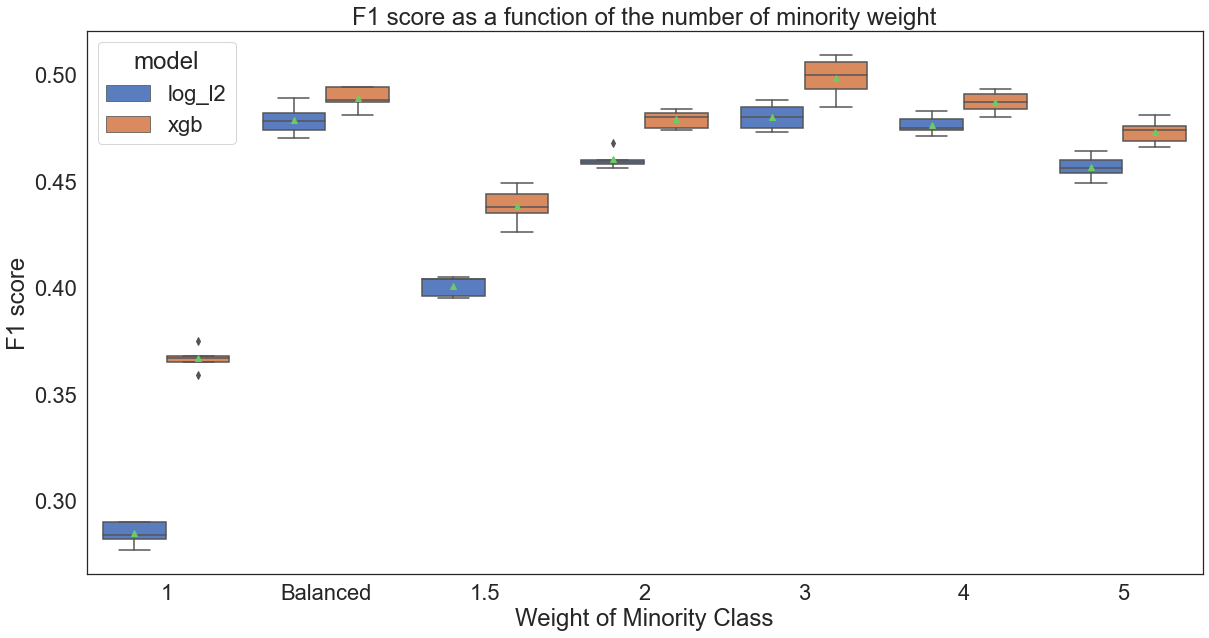

In [ ]:
box_df = pd.DataFrame(np.array(scores_l2))
box_df_2 = pd.DataFrame(np.array(scores_xgb))
box_df['Weights'], box_df_2['Weights'] = [1, 'Balanced', 1.5, 2 ,3, 4,5], [1, 'Balanced', 1.5, 2 ,3,4, 5]
box_df['model'], box_df_2['model'] = 'log_l2', 'xgb'
box_df = pd.concat([box_df, box_df_2])
box_df = box_df.melt(id_vars=['Weights', 'model'])


plt.figure(figsize=(20,10))
sns.set_style("white")
sns.boxplot(x="Weights", 
            y="value", 
            hue='model',
            data=box_df, 
            showmeans=True);
plt.xlabel('Weight of Minority Class')
plt.ylabel('F1 score')
plt.title('F1 score as a function of the number of minority weight');

In [ ]:
clf = LogisticRegression(penalty='l2',solver='saga',C=.01,class_weight={0:1, 1:3},max_iter=1000)
ans = run_model(model_name='log_l2_3weight',model=clf, x=X_train, y=y_train, grp=train['animal_id'])
val_df = pd.concat([val_df, ans], ignore_index=True)

clf_xgb = xgb.XGBClassifier(random_state=1, scale_pos_weight=3)
ans = run_model(model_name='xgb_tree_3weight',model=clf_xgb, x=X_train, y=y_train, grp=train['animal_id'])
val_df = pd.concat([val_df, ans], ignore_index=True)


log_l2_3weight : Done!
xgb_tree_3weight : Done!


# Feature Importance

1. Manual Cleaning

In [ ]:
#Check correlation between variables, see if anything is highly correlated:
corr_df = abs(X_train.corr())

for col in corr_df:
    temp_df = corr_df[corr_df[col] >= 0.95]
    if temp_df.shape[0] > 1:
        print('{} has {} highly correlated features associated with it.'.format(col, temp_df.shape[0]))



In [ ]:
corr_df = pd.concat([X_train, y_train], axis=1)
mask = abs(corr_df.corr())[y].sort_values() < 0.05
index_list = mask.index[mask == True]
X_train_manual_clean = X_train.loc[:, ~X_train.columns.isin(index_list)]
datasets_to_run['manual_clean'] = X_train_manual_clean


In [ ]:
#Train all of our models
for model_name, model_run in model_run_dict.items():
    ans = run_model(model_name=model_name+'_manual_clean',model=model_run, x=X_train_manual_clean, y=y_train, grp=train['animal_id'])
    val_df = pd.concat([val_df, ans], ignore_index=True)

log_l2_manual_clean : Done!
tree_manual_clean : Done!
rfc_tree_manual_clean : Done!
xgb_tree_manual_clean : Done!


2. Boruta

In [ ]:
#Takes ~7min to run so flag to turn it off or on
run_boruta_process_flag = False

if run_boruta_process_flag:
    
    ### initialize Boruta
    feat_selector = BorutaPy(model_run_dict['xgb_tree'], n_estimators='auto', random_state=1)
    # fit Boruta (it accepts np.array, not pd.DataFrame)
    train_X_np = X_train.to_numpy()
    train_Y_np = y_train.to_numpy()

    feat_selector.fit(train_X_np, train_Y_np)


# Results
boruta_features = X_train.columns

boruta_strong_features = boruta_features[feat_selector.support_].values.tolist()
boruta_weak_features = boruta_features[feat_selector.support_weak_].values.tolist()

print('Features to keep per Boruta:', boruta_strong_features)
print('Features that are weak per Boruta:', boruta_weak_features)

# select relevant features per Boruta and output column 
train_df_selected_strong_features_boruta = X_train[boruta_strong_features]
train_df_all_selected_features_boruta = X_train[boruta_strong_features + boruta_weak_features]

datasets_to_run['boruta_strong'] = train_df_selected_strong_features_boruta
datasets_to_run['boruta_all'] = train_df_all_selected_features_boruta

#Train all of our models
for i in ['boruta_strong', 'boruta_all']:
    for model_name, model_run in model_run_dict.items():
        ans = run_model(model_name=model_name+"_"+i,model=model_run, x=datasets_to_run[i], y=y_train, grp=train['animal_id'])
        val_df = pd.concat([val_df, ans], ignore_index=True)

# View Baseline Results

In [ ]:
val_df

,test_accuracy,test_balanced_accuracy,test_roc_auc,test_precision,test_recall,test_f1,model_name
0,0.747,0.500,0.500,0.000,0.000,0.000,dummy
1,0.774,0.577,0.703,0.712,0.178,0.285,log_l2
2,0.716,0.618,0.619,0.436,0.421,0.428,tree
3,0.779,0.628,0.707,0.619,0.323,0.424,rfc_tree
4,0.786,0.607,0.728,0.729,0.245,0.367,xgb_tree
5,0.687,0.649,0.705,0.414,0.571,0.480,log_l2_oversample
6,0.701,0.617,0.619,0.415,0.446,0.430,tree_oversample
7,0.753,0.641,0.702,0.515,0.413,0.458,rfc_tree_oversample
8,0.707,0.665,0.725,0.440,0.578,0.499,xgb_tree_oversample
9,0.717,0.639,0.692,0.445,0.482,0.463,log_l2_smote


# Fine Tune Models

1. test other hyperparams

5 : Done!
5 : Done!
5 : Done!
5 : Done!
5 : Done!
5 : Done!


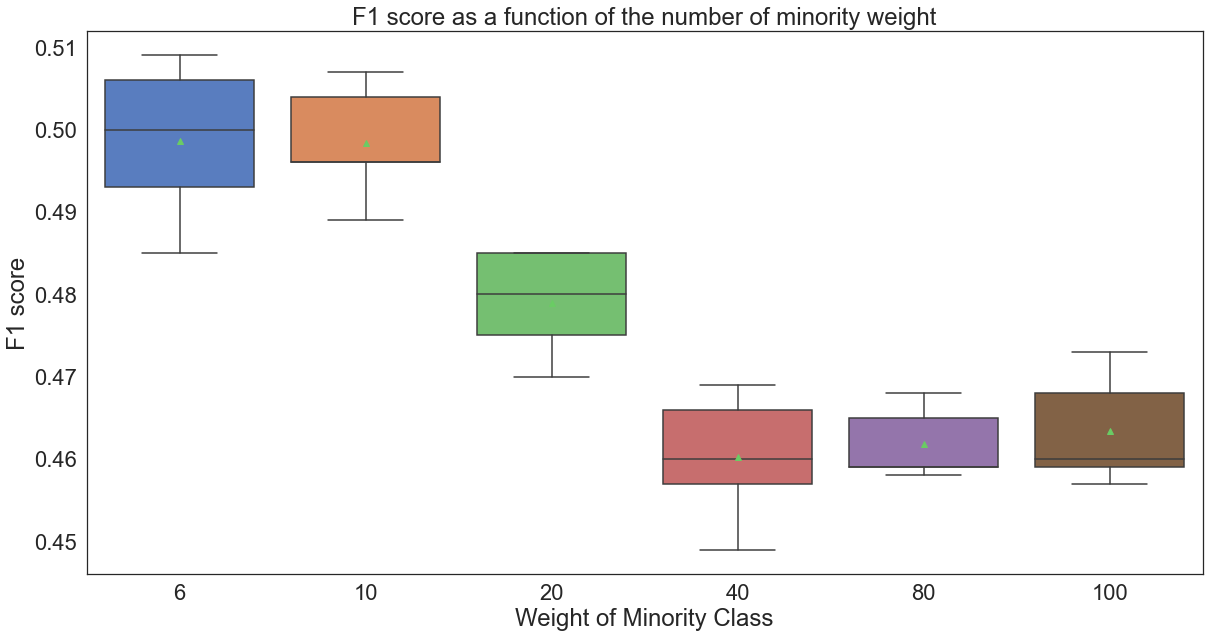

In [ ]:
scores_xgb = []
depth_list = [3, 4, 6, 10, 20, 40]
for depth in depth_list:
    clf = xgb.XGBClassifier(random_state=1, scale_pos_weight=3, max_depth=depth)
    ans, score_list = run_model(model_name=depth,model=clf, x=X_train, y=y_train, grp=train['animal_id'], return_scores=1)
    scores_xgb.append(score_list['test_f1'])

box_df = pd.DataFrame(np.array(scores_xgb))
box_df['Weights'] = depth_list
box_df = box_df.melt(id_vars=['Weights'])


plt.figure(figsize=(20,10))
sns.set_style("white")
sns.boxplot(x="Weights", 
            y="value", 
            data=box_df, 
            showmeans=True);
plt.xlabel('Weight of Minority Class')
plt.ylabel('F1 score')
plt.title('F1 score as a function of the max tree depth');

50 : Done!
100 : Done!
120 : Done!
150 : Done!
200 : Done!
400 : Done!


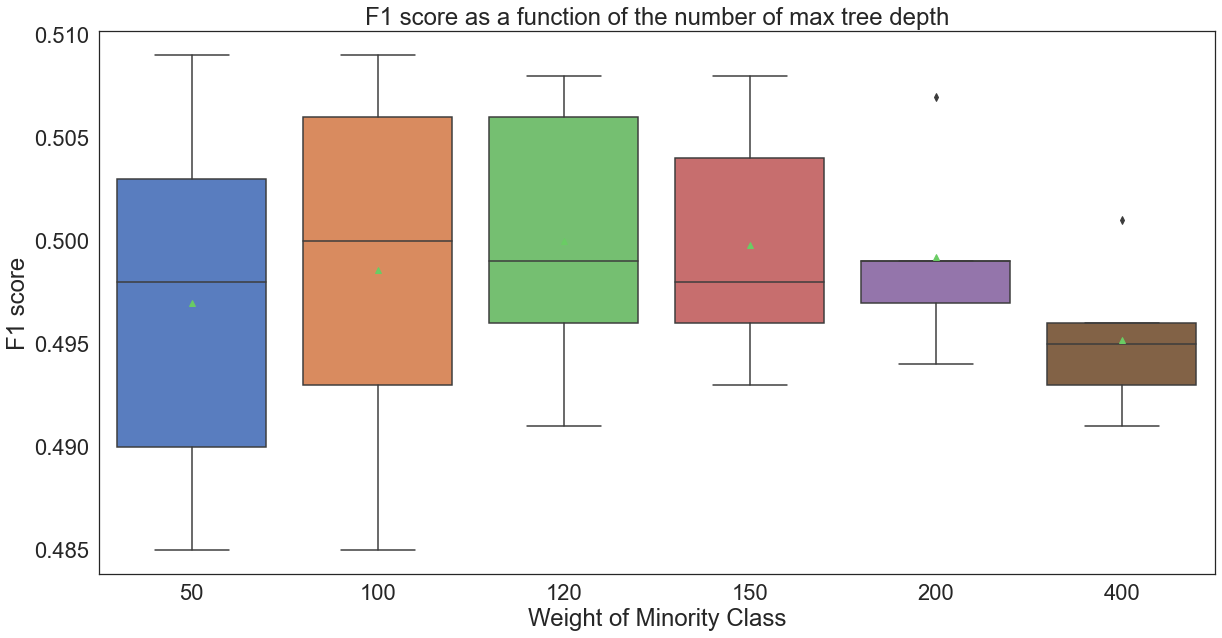

In [14]:
scores_xgb = []
n_estimators_list = [50, 100, 120, 150, 200, 400]
for est in n_estimators_list:
    clf = xgb.XGBClassifier(random_state=1, scale_pos_weight=3, max_depth=6, n_estimators=est)
    ans, score_list = run_model(model_name=est,model=clf, x=X_train, y=y_train, grp=train['animal_id'], return_scores=1)
    scores_xgb.append(score_list['test_f1'])

box_df = pd.DataFrame(np.array(scores_xgb))
box_df['Weights'] = n_estimators_list
box_df = box_df.melt(id_vars=['Weights'])


plt.figure(figsize=(20,10))
sns.set_style("white")
sns.boxplot(x="Weights", 
            y="value", 
            data=box_df, 
            showmeans=True);
plt.xlabel('Weight of Minority Class')
plt.ylabel('F1 score')
plt.title('F1 score as a function of the number of tree estimators');

Taken together it seems like we quickly overfit if we maximize depth or use many estimators, instead we can finish the job by running a grid search.

Extra Fluff:

In [ ]:
extra_run = False
if extra_run:
    tester = X_train.copy()
    tester['age^2'] = tester['age']**2
    def interact_mix(df):
        breed_col = df.loc[:, df.columns.str.contains('breed_')]
        for col in breed_col:
            df[col+'_mix'] = df[col]*df['mixed_1']
        return df
    tester = tester.pipe(interact_mix)

    from sklearn.preprocessing import PolynomialFeatures
    """poly = PolynomialFeatures(2)
    output = poly.fit_transform(X_train)
    tester =pd.DataFrame(output, columns=poly.get_feature_names_out())
    tester = tester.loc[:, ~tester.columns.str.contains('(breed_|color_).*\^2.*')]"""
    scores = cross_validate(model_run_dict['xgb_tree'], tester, y_train, scoring=('accuracy', 
    'balanced_accuracy', 'roc_auc', 'precision'), return_train_score=True, groups=train_clean['animal_id'], verbose=2, n_jobs=-1)
    scores

In [ ]:
clf = xgb.XGBClassifier(random_state=1, scale_pos_weight=3)
clf.fit(X_train, y_train)
predicted = clf.predict(X_val)
print(classification_report(y_val, predicted))
val_clean['predicted'] = predicted
val_clean['correct'] = np.where(val_clean['predicted'] == val_clean['not_adopted'], 1, 0)
val_clean['correct'].value_counts()
val_clean[['correct', 'outcome_type']].value_counts()

              precision    recall  f1-score   support

           0       0.85      0.73      0.79     12518
           1       0.42      0.59      0.49      4061

    accuracy                           0.70     16579
   macro avg       0.63      0.66      0.64     16579
weighted avg       0.74      0.70      0.71     16579

